In [1]:
import os
import sys

local_path = os.getcwd()
# 设置工作目录为项目的主目录
os.chdir(os.path.join(local_path, "../../"))  # 使用相对路径将工作目录切换到 project 文件夹
print("Current working directory:", os.getcwd())
project_path = os.path.abspath(os.path.join(local_path, "../../"))
sys.path.append(project_path)   #将模块查找路径切换

save_path = os.path.join(project_path, "result/analyse_SIL/")
print(save_path)

Current working directory: /home/yixiong_ren/work/FBM
/home/yixiong_ren/work/FBM/result/analyse_SIL/


In [2]:
import torch
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 设置随机种子

In [3]:
import numpy as np
import random

def set_seed(seed):
    # 设置 Python 内置 random 库的随机种子
    random.seed(seed)
    
    # 设置 NumPy 的随机种子
    np.random.seed(seed)
    
    # 设置 PyTorch 的随机种子
    torch.manual_seed(seed)
    
    # 如果使用 GPU 进行训练，则需设置以下两个以保证完全的可重复性
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 如果使用多块 GPU
    
    # 设置 CuDNN 后端以确保结果一致性
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 使用示例
set_seed(42)  # 42 是一个示例种子数，您可以根据需求更改

# 加载数据集

## 生成两个高斯分布的数据

In [4]:
from torch.utils.data import TensorDataset, DataLoader
import math

def generate_sphere_data_with_overlap(
    num_samples_per_class, dimensions, radius_0, radius_1, center_0, center_1
):
    """
    生成两个类别的数据集，每类数据分布在一个高维球体内，并指定球心位置。
    如果生成的点同时属于两类（即满足两个球体的半径约束），则将其标记为标签 2。
    
    :param num_samples_per_class: 每个类别的样本数量
    :param dimensions: 高维空间的维数
    :param radius_0: 类别 0 球体的半径
    :param radius_1: 类别 1 球体的半径
    :param center_0: 类别 0 球体的球心位置 (list or tensor)
    :param center_1: 类别 1 球体的球心位置 (list or tensor)
    :return: 数据集 (features, labels)
    """
    def generate_points(num_samples, dimensions, radius_0, radius_1, center_0, center_1, add_label=1):
        data = []
        labels = []
        center_tensor_0 = torch.tensor(center_0, dtype=torch.float32)
        center_tensor_1 = torch.tensor(center_1, dtype=torch.float32)
        
        while len(data) < num_samples:
            # 从标准高斯分布生成点
            point = torch.randn(dimensions) + center_tensor_0
            
            # 计算点到两个球心的距离
            distance_to_0 = torch.norm(point - center_tensor_0)
            distance_to_1 = torch.norm(point - center_tensor_1)
            
            # 检查点是否在类别 0 和类别 1 的球体内
            in_sphere_0 = distance_to_0 <= radius_0
            in_sphere_1 = distance_to_1 <= radius_1
            
            if in_sphere_0 and in_sphere_1:
                # 如果点同时属于两类，标记为 2
                data.append(point)
                labels.append(2)
            elif in_sphere_0:
                # 如果点仅属于类别 0
                data.append(point)
                labels.append(add_label)


        return torch.stack(data), torch.tensor(labels, dtype=torch.long)
    
    # 生成数据和标签
    features1, labels1 = generate_points(
        num_samples_per_class,  # 生成更多点以处理两类重叠的情况
        dimensions,
        radius_0,
        radius_1,
        center_0,
        center_1,
        add_label = 0
    )
    features2, labels2 = generate_points(
        num_samples_per_class,  # 生成更多点以处理两类重叠的情况
        dimensions,
        radius_1,
        radius_0,
        center_1,
        center_0,
        add_label = 1
    )
    features, labels = torch.cat((features1, features2), dim=0), torch.cat((labels1, labels2), dim=0)

    return features, labels

def generate_circle_data_with_overlap(
    num_samples_per_class, dimensions, radius_0, radius_1, center, mix_rate
):
    """
    生成两个类别的数据集，每类数据分布在一个高维球体内，这些数据具有相同球心。在不同半径下属于不同的类别。
    存在混合半径，如果在该半径下，无法区分两类数据，用另一个标签标记。
    
    :param num_samples_per_class: 每个类别的样本数量
    :param dimensions: 高维空间的维数
    :param radius_0:    类别 0 球体的半径，最长的半径
    :param radius_1:    类别 1 球体的半径
    :param center:      球体的球心位置 (list or tensor)
    :param mix_rate:    混合半径占占两个半径的差别的比例
    :return: 数据集 (features, labels)
    """
    def generate_points(num_samples, dimensions, radius_0, radius_1, radius_mix, center):
        # radius_0 是最长的半径，radius_1是次长的半径
        data = []
        labels = []
        center_tensor_0 = torch.tensor(center, dtype=torch.float32)
        
        while len(data) < num_samples:
            # 从均匀分布生成点
            point = (torch.rand(dimensions)-0.5) * 2 * radius_0/math.sqrt(dimensions) 
            # 计算点到球心的距离
            distance_to_center = torch.norm(point)
            point += center_tensor_0
            
            # 检查点是否在类别 0 和类别 1 的球体内
            in_sphere_0 = distance_to_center <= radius_0
            in_sphere_1 = distance_to_center <= radius_1
            in_sphere_mix = distance_to_center <= radius_mix
            
            if in_sphere_1:         #是否在范围内
                data.append(point)
                labels.append(1)
            elif in_sphere_mix:
                data.append(point)
                labels.append(2)
            elif in_sphere_0:
                data.append(point)
                labels.append(0)

        return torch.stack(data), torch.tensor(labels, dtype=torch.long)
    
    radius_mix = (radius_0 - radius_1) * mix_rate + radius_1
    # 生成数据和标签
    features, labels = generate_points(
        num_samples_per_class,  # 生成更多点以处理两类重叠的情况
        dimensions,
        radius_0,
        radius_1,
        radius_mix,
        center
    )


    #features, labels = torch.cat((features), dim=0), torch.cat((labels), dim=0)

    return features, labels

## 生成三个高斯分布的函数

In [5]:
def generate_three_sphere_with_overlap(
    num_samples_per_class, dimensions, radius_0, radius_1, radius_2, center_0, center_1, center_2
):
    """
    生成两个类别的数据集，每类数据分布在一个高维球体内，并指定球心位置。
    如果生成的点同时属于两类（即满足两个球体的半径约束），则将其标记为标签 2。
    
    :param num_samples_per_class: 每个类别的样本数量
    :param dimensions: 高维空间的维数
    :param radius_0: 类别 0 球体的半径
    :param radius_1: 类别 1 球体的半径
    :param center_0: 类别 0 球体的球心位置 (list or tensor)
    :param center_1: 类别 1 球体的球心位置 (list or tensor)
    :return: 数据集 (features, labels)
    """
    def generate_points(num_samples, dimensions, radius_0, radius_1, radius_2, center_0, center_1, center_2, add_label=1):
        data = []
        labels = []
        center_tensor_0 = torch.tensor(center_0, dtype=torch.float32)
        center_tensor_1 = torch.tensor(center_1, dtype=torch.float32)
        center_tensor_2 = torch.tensor(center_2, dtype=torch.float32)
        
        while len(data) < num_samples:
            # 从标准高斯分布生成点
            point = torch.randn(dimensions) + center_tensor_0
            
            # 计算点到两个球心的距离
            distance_to_0 = torch.norm(point - center_tensor_0)
            distance_to_1 = torch.norm(point - center_tensor_1)
            distance_to_2 = torch.norm(point - center_tensor_2)
            
            # 检查点是否在类别 0 和类别 1 的球体内
            in_sphere_0 = distance_to_0 <= radius_0
            in_sphere_1 = distance_to_1 <= radius_1
            in_sphere_2 = distance_to_2 <= radius_2
            
            if in_sphere_0:         #是否在范围内
                if in_sphere_1 or in_sphere_2:      #如果同属于其它类别，则认为不可分割
                    data.append(point)
                    labels.append(3)
                else: 
                    data.append(point)
                    labels.append(add_label)

        return torch.stack(data), torch.tensor(labels, dtype=torch.long)
    
    # 生成数据和标签
    features1, labels1 = generate_points(
        num_samples_per_class,  # 生成更多点以处理两类重叠的情况
        dimensions,
        radius_0,
        radius_1,
        radius_2,
        center_0,
        center_1,
        center_2,
        add_label = 0
    )
    features2, labels2 = generate_points(
        num_samples_per_class,  # 生成更多点以处理两类重叠的情况
        dimensions,
        radius_1,
        radius_0,
        radius_2,
        center_1,
        center_0,
        center_2,
        add_label = 1
    )
    features3, labels3 = generate_points(
        num_samples_per_class,  # 生成更多点以处理两类重叠的情况
        dimensions,
        radius_2,
        radius_0,
        radius_1,
        center_2,
        center_0,
        center_1,
        add_label = 2
    )
    features, labels = torch.cat((features1, features2, features3), dim=0), torch.cat((labels1, labels2, labels3), dim=0)

    return features, labels

## 绘图

In [6]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 可视化函数：将数据降维到 2D 并可视化
def visualize_2d(features, labels, savepath=None):
    """
    使用 t-SNE 将高维数据降维到 2D 并可视化。
    :param features: 高维特征数据 (tensor or numpy array)
    :param labels: 标签 (tensor or numpy array)
    """
    # 转换为 numpy
    features_np = features.detach().numpy()
    labels_np = labels.numpy()

    # 使用 t-SNE 降维到 2D
    _, dims =features.shape
    
    if dims > 2:
        #tsne = TSNE(n_components=2, random_state=42, perplexity=40)
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features_np)
        explained_variance_ratio = pca.explained_variance_ratio_
    else:
        features_2d = features_np
        explained_variance_ratio = None

    # 绘制 2D 散点图
    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        mask = labels_np == label
        plt.scatter(
            features_2d[mask, 0],
            features_2d[mask, 1],
            label=f"Class {label}",
            alpha=0.6
        )
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title("Visualization of High-Dimensional Data")
    plt.legend()
    plt.grid(True)

    # 显示 PCA 信息占比
    if explained_variance_ratio is not None:
        info_text = f"Explained Variance:\nDim 1: {explained_variance_ratio[0]:.2%}\nDim 2: {explained_variance_ratio[1]:.2%}"
        plt.text(0.05, 0.95, info_text, transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.2))

    if savepath is None:
        plt.show()
    else:
        plt.savefig(savepath+'.png')
    plt.close()
    return None

In [7]:
'''
#普通两类高斯分布数据
num_samples = 600
dimensions = 5
radius_0 = 1.0
radius_1 = 1.0
center_0 = [0.5] * dimensions  # 类别 0 的球心位置
center_1 = [1.5] * dimensions  # 类别 1 的球心位置


features, labels = generate_sphere_data_with_overlap(
    num_samples, dimensions, radius_0, radius_1, center_0, center_1
)

test_features, test_labels = generate_sphere_data_with_overlap(
    num_samples, dimensions, radius_0, radius_1, center_0, center_1
)
'''

'''
#同心两个高斯分布
# 示例：生成每类 500 个样本的高维数据
num_samples = 200
dimensions = 2
radius_0 = 2.0
radius_1 = 1.0
mix_rate = 0.2

center = [0.0] * dimensions  # 球心位置


# 生成数据
features, labels = generate_circle_data_with_overlap(
    num_samples, dimensions, radius_0, radius_1, center, mix_rate
)
test_features, test_labels = generate_circle_data_with_overlap(
    num_samples, dimensions, radius_0, radius_1, center, mix_rate
)
'''

'''
# 找到标签为 2 的索引
idx_2 = (labels == 2)
num_idx_2 = idx_2.sum().item()
# 随机生成 0 或 1 的替换标签
random_labels = torch.randint(0, 2, (num_idx_2,), dtype=torch.long)
# 替换标签
labels[idx_2] = random_labels
'''

'\n# 找到标签为 2 的索引\nidx_2 = (labels == 2)\nnum_idx_2 = idx_2.sum().item()\n# 随机生成 0 或 1 的替换标签\nrandom_labels = torch.randint(0, 2, (num_idx_2,), dtype=torch.long)\n# 替换标签\nlabels[idx_2] = random_labels\n'

In [8]:
# 示例：生成每类 500 个样本的高维数据
num_samples = 400
dimensions = 2
radius_0 = 1.1
radius_1 = 1.1
radius_2 = 1.1
'''
center_0 = [0.6] * dimensions  # 类别 0 的球心位置
center_1 = [1.0] * dimensions  # 类别 1 的球心位置
center_2 = [0.8] * dimensions  # 类别 2 的球心位置
'''
center_0 = [0.0, 0.0]
center_1 = [2.0, 0.0]
center_2 = [1.0, np.sqrt(3)]


# 生成数据
train_features, train_labels = generate_three_sphere_with_overlap(
    num_samples, dimensions, radius_0, radius_1, radius_2, center_0, center_1, center_2
)
test_features, test_labels = generate_three_sphere_with_overlap(
    num_samples, dimensions, radius_0, radius_1, radius_2, center_0, center_1, center_2
)


# 找到标签为 3 的索引
idx_3 = (train_labels == 3)
num_idx_3 = idx_3.sum().item()
# 随机生成 0、1、2 的替换标签
random_labels = torch.randint(0, 3, (num_idx_3,), dtype=torch.long)
# 替换标签
train_labels[idx_3] = random_labels


In [9]:
batch_size = 64  # 设置每个 batch 的大小
dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 观察训练与测试集的分布

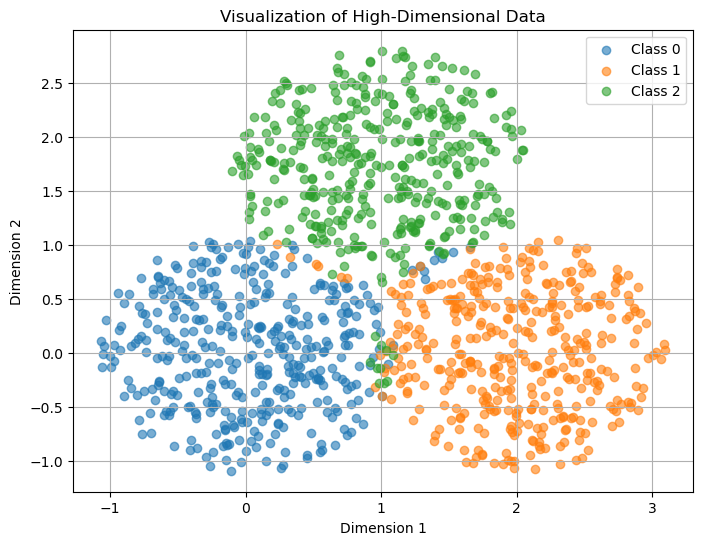

In [10]:
visualize_2d(train_features, train_labels)

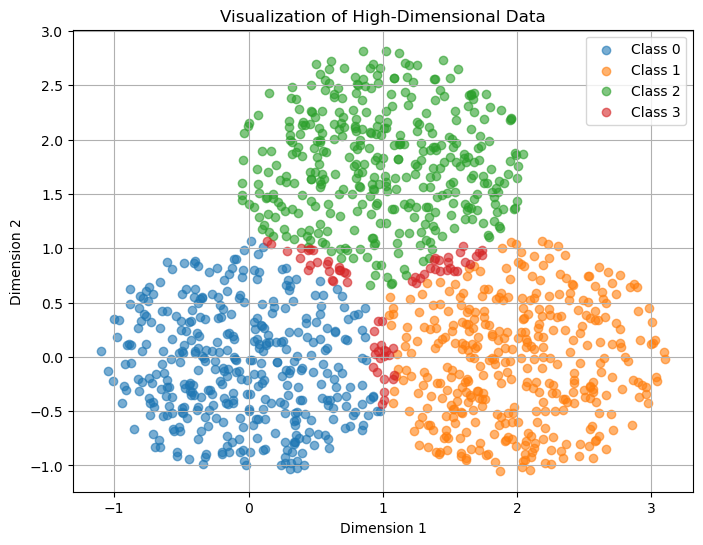

In [11]:
visualize_2d(test_features, test_labels)

# 给出数据之间的距离

In [12]:
def fast_FBDistance(features, labels):
    """
    计算不同类别之间的平均距离矩阵（Fermi-Bose 距离矩阵）。
    输入:
        features: 张量，形状为 (N, D)，每一行是一个样本的特征向量。
        labels: 张量，形状为 (N,)，表示样本的类别标签。
    输出:
        labels_matrix: 张量，形状为 (C, C)，表示类别间的平均距离矩阵。
            - 对角线 (i, i): 表示类别 i 内样本之间的平均距离。
            - 非对角线 (i, j): 表示类别 i 和类别 j 的样本间的平均距离。
    """

    # 获取所有唯一的类别标签
    labels_list = torch.unique(labels)
    labels_count = len(labels_list)  # 唯一类别的数量

    # 构建每个类别对应的样本特征集合
    # features_list[i] 是类别 i 的所有样本特征的列表
    features_list = [[] for _ in range(labels_count)]
    for i in range(labels_count):
        idx_label = (labels == i)  # 找到标签等于 i 的样本索引
        features_list[i] = features[idx_label]  # 取出属于类别 i 的样本特征

    # 初始化类别间距离矩阵 labels_matrix
    # 形状为 (C, C)，初始值为 0
    labels_matrix = torch.zeros(labels_count, labels_count)

    # 计算类别间的平均距离
    for i in range(labels_count):
        for j in range(i, labels_count):  # 只计算上三角部分 (i <= j)
            # 计算类别 i 和类别 j 的样本之间的两两差值
            # features_list[i].unsqueeze(0): 类别 i 的样本扩展维度以进行广播
            # features_list[j].unsqueeze(1): 类别 j 的样本扩展维度以进行广播
            sample_diff = features_list[i].unsqueeze(0) - features_list[j].unsqueeze(1)

            # 计算两两样本的欧几里得距离矩阵 D_matrix
            # D_matrix 的形状为 (len(features_list[i]), len(features_list[j]))
            D_matrix = torch.norm(sample_diff, dim=2)

            # 计算类别 i 和类别 j 的平均距离
            # 总距离除以样本对的数量
            labels_matrix[i, j] = torch.sum(D_matrix) / (len(features_list[i]) * len(features_list[j]))

    return labels_matrix  # 返回类别间的平均距离矩阵

fast_FBDistance(train_features, train_labels)

tensor([[0.9663, 2.1016, 2.0951],
        [0.0000, 0.9588, 2.1253],
        [0.0000, 0.0000, 0.9681]])

# 定义FBM的单层网络

In [13]:
import torch.nn as nn
# 定义单层神经网络模型
class SingleLayerNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SingleLayerNN, self).__init__()
        self.input_size = input_size
        self.linear = nn.Linear(input_size, output_size)
        self.activation = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.view(-1, self.input_size)  # 展平图像
        out = self.linear(x)
        out = (torch.tanh(out) + 1)/2.0
        #out = self.activation(out)
        return out

# 定义Loss函数

In [14]:
class FBMLoss(nn.Module):
    def __init__(self, input_size, lam, df, alpha):
        super(FBMLoss, self).__init__()
        self.len_out = input_size
        self.lam =lam
        self.a = df
        self.b = alpha

    def forward(self, inputs, targets, weights):
        normal = 0.5 * self.lam / self.len_out * torch.norm(weights, p=2) ** 2
        #print("normal", normal)
        #loss = FermiBose(inputs, targets, self.a, self.b) + normal
        loss = FermiBose_parallel(inputs, targets, self.a, self.b) + normal
        #print("diff", fast_FermiBose(inputs, targets, self.d_f) - FermiBose(inputs, targets, self.d_f))
        return loss


In [15]:
import torch.nn.functional as F
def FermiBose_parallel(sample, labels, a, b, if_onehot=False):
    batch, hidden1_features = sample.shape
    if not if_onehot: labels = F.one_hot(labels).float()
    # 使用广播计算每对样本之间的 L2 距离的平方和
    sample_diff = sample.unsqueeze(1) - sample.unsqueeze(0)  # 扩展维度并相减，得到 (batch, batch, outdim)
    D_matrix = torch.norm(sample_diff, dim=2)# 对最后一个维度求和，得到 (batch, batch) 矩阵

    #mask = ~torch.eye(batch, dtype=bool, device=sample.device)  # 非对角线部分为 True

    # 计算phi(.)
    v = lambda x: a / (x+ 1e-5) + b * x - math.sqrt(a * b)
    phi_matrix = v(D_matrix) 

    # 计算标签矩阵的乘积，结果是 (batch_size, batch_size)，并且只保留上三角，去除重复以及自身关联项
    label_matrix = torch.triu(labels @ labels.T, diagonal=1).detach()

    # 计算bose_loss
    same_label_count = max(torch.sum(label_matrix), 1)
    bose_loss = torch.triu(label_matrix*phi_matrix, diagonal=1).sum()/same_label_count

    # 计算fermi_loss
    diff_label_count = max(batch*(batch-1)/2 - same_label_count, 1)
    fermi_loss = torch.triu((label_matrix-1)*phi_matrix, diagonal=1).sum()/diff_label_count

    # 总loss
    loss = bose_loss + fermi_loss
    #print("parallel", same_label_count, diff_label_count)
    #print("parallel", bose_loss, fermi_loss)
    return loss

"""测试代码
# 样本数据
batch_size = 600
hidden_features = 6
sample = torch.rand(batch_size, hidden_features, device='cuda')  # GPU 加速
labels = torch.randint(0, 2, (batch_size,), device='cuda')  # 随机生成标签

# 检查 DataLoader 输出
for sample, labels in train_loader:
    #print("Batch features shape:", batch_features.shape)
    #print("Batch labels shape:", batch_labels.shape)
    break
# 超参数
a = 1.0
b = 0.5

# 计算损失
loss = FermiBose(sample, labels, a, b) - FermiBose_parallel(sample, labels, a, b)
print("Loss:", loss.item())

"""

'测试代码\n# 样本数据\nbatch_size = 600\nhidden_features = 6\nsample = torch.rand(batch_size, hidden_features, device=\'cuda\')  # GPU 加速\nlabels = torch.randint(0, 2, (batch_size,), device=\'cuda\')  # 随机生成标签\n\n# 检查 DataLoader 输出\nfor sample, labels in train_loader:\n    #print("Batch features shape:", batch_features.shape)\n    #print("Batch labels shape:", batch_labels.shape)\n    break\n# 超参数\na = 1.0\nb = 0.5\n\n# 计算损失\nloss = FermiBose(sample, labels, a, b) - FermiBose_parallel(sample, labels, a, b)\nprint("Loss:", loss.item())\n\n'

# 训练FBM

In [18]:
import torch.optim as optim
import torch.nn.functional as F

# 定义超参数
input_size = dimensions
hidden_dim = 25
num_classes = 10      # MNIST有10个类别
learning_rate = 0.01
num_epochs = 100
batch_size = 64
b = 1.5
a = 2

# 实例化模型、定义损失函数和优化器
model = SingleLayerNN(input_size, hidden_dim).to(device)
criterion = FBMLoss(hidden_dim, 0.01, a, b)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
# 训练模型
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # 将图像和标签移动到 GPU 上
        images = images.view(-1, input_size).to(device)  # 展平图像并转移到 GPU
        labels = labels.to(device)  # 标签移动到 GPU
        #labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()
        
        # 前向传播
        outputs = model(images)
        #loss = criterion(outputs, labels_one_hot, model.linear.weight)
        loss = criterion(outputs, labels, model.linear.weight)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    '''分析代码'''
    with torch.no_grad():
        local_data = train_features.view(-1, input_size).to(device)
        analyse_data = model(local_data).cpu()
        
        local_save_path = os.path.join(save_path, f"output_{a:.2f}_{b:.2f}/")
        os.makedirs(local_save_path, exist_ok=True)

        visualize_2d(analyse_data, train_labels.cpu(), os.path.join(local_save_path, f"{epoch}"))   #画出最后的结果
        out_dis = fast_FBDistance(analyse_data, train_labels.cpu())
        # 计算对角项的和
        diagonal_sum = torch.diag(out_dis).sum()

        # 计算非对角项的和
        total_sum = out_dis.sum()
        non_diagonal_sum = total_sum - diagonal_sum
        with open(os.path.join(local_save_path, "distance.txt"), "a") as file:
            file.write("="*20+"\n"+f"epoch={epoch}"+"\n")
            file.write(str(out_dis) + "\n")  # 写入数据并换行
            file.write(f"Bosen={diagonal_sum}\t Fermi={non_diagonal_sum}\n")
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.5705
Epoch [2/100], Loss: 0.0040
Epoch [3/100], Loss: -0.0801
Epoch [4/100], Loss: -0.5637
Epoch [5/100], Loss: -1.0373
Epoch [6/100], Loss: -1.1604
Epoch [7/100], Loss: -0.9940
Epoch [8/100], Loss: -0.9287
Epoch [9/100], Loss: -1.4837
Epoch [10/100], Loss: -1.4005
Epoch [11/100], Loss: -1.2689
Epoch [12/100], Loss: -1.8135
Epoch [13/100], Loss: -1.2896
Epoch [14/100], Loss: -2.0578
Epoch [15/100], Loss: -1.7121
Epoch [16/100], Loss: -1.5506
Epoch [17/100], Loss: -1.7549
Epoch [18/100], Loss: -1.9167
Epoch [19/100], Loss: -1.6118
Epoch [20/100], Loss: -1.5647
Epoch [21/100], Loss: -1.9584
Epoch [22/100], Loss: -2.5577
Epoch [23/100], Loss: -1.9349
Epoch [24/100], Loss: -2.1520
Epoch [25/100], Loss: -1.9751
Epoch [26/100], Loss: -2.0439
Epoch [27/100], Loss: -2.4009
Epoch [28/100], Loss: -2.4152
Epoch [29/100], Loss: -2.1604
Epoch [30/100], Loss: -1.6191
Epoch [31/100], Loss: -2.2459
Epoch [32/100], Loss: -2.0767
Epoch [33/100], Loss: -2.5091
Epoch [34/100], Loss:

In [23]:
"""写成可以搜索的形式"""
def more_data(a, b):
    # 定义超参数
    input_size = dimensions
    hidden_dim = 10
    num_classes = 10      # MNIST有10个类别
    learning_rate = 0.01
    num_epochs = 100
    batch_size = 64
    #b = 1.5
    #a = 2

    # 实例化模型、定义损失函数和优化器
    model = SingleLayerNN(input_size, hidden_dim).to(device)
    criterion = FBMLoss(hidden_dim, 0.01, a, b)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    # 训练模型
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            # 将图像和标签移动到 GPU 上
            images = images.view(-1, input_size).to(device)  # 展平图像并转移到 GPU
            labels = labels.to(device)  # 标签移动到 GPU
            #labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()
            
            # 前向传播
            outputs = model(images)
            #loss = criterion(outputs, labels_one_hot, model.linear.weight)
            loss = criterion(outputs, labels, model.linear.weight)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        '''分析代码'''
        with torch.no_grad():
            local_data = train_features.view(-1, input_size).to(device)
            analyse_data = model(local_data).cpu()
            
            local_save_path = os.path.join(save_path, f"train2/hidden{hidden_dim}_a{a:.2f}_b{b:.2f}/")
            os.makedirs(local_save_path, exist_ok=True)

            visualize_2d(analyse_data, train_labels.cpu(), os.path.join(local_save_path, f"{epoch}"))   #画出最后的结果
            out_dis = fast_FBDistance(analyse_data, train_labels.cpu())
            # 计算对角项的和
            diagonal_sum = torch.diag(out_dis).sum()

            # 计算非对角项的和
            total_sum = out_dis.sum()
            non_diagonal_sum = total_sum - diagonal_sum
            with open(os.path.join(local_save_path, "distance.txt"), "a") as file:
                file.write("="*20+"\n"+f"epoch={epoch}"+"\n")
                file.write(str(out_dis) + "\n")  # 写入数据并换行
                F_B = non_diagonal_sum/diagonal_sum
                file.write(f"Bosen={diagonal_sum:.4f}\t Fermi={non_diagonal_sum:.4f}\t Fermi_Bosen={F_B:.4f}\n")
        
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

for a in np.linspace(0.3, 2, 10):
    for b in np.linspace(0.3, 2, 10):
        more_data(a, b)

# 绘制在测试集上的表现

In [ ]:
with torch.no_grad():
    out_features = model(test_features.to(device)).cpu()
visualize_2d(out_features, test_labels)

# 计算范数从而说明分布情况

范数均值: 31.60, 范数标准差: 0.71


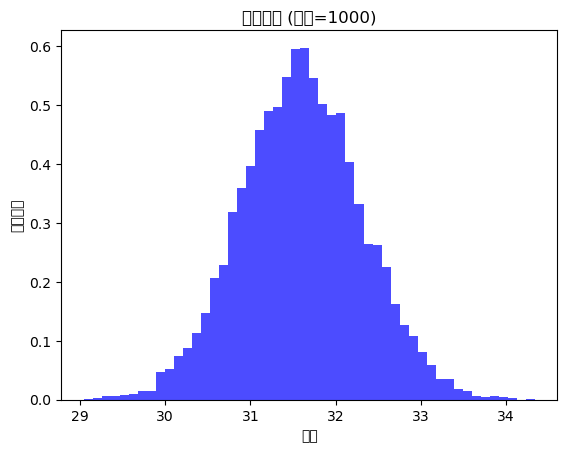

: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 随机生成高维数据
d = 1000  # 维度
n_samples = 10000  # 样本数
data = np.random.randn(n_samples, d)  # 标准正态分布

# 计算每个点的范数
norms = np.linalg.norm(data, axis=1)

# 统计范数的均值和标准差
mean_norm = np.mean(norms)
std_norm = np.std(norms)
print(f"范数均值: {mean_norm:.2f}, 范数标准差: {std_norm:.2f}")

# 绘制范数的分布
plt.hist(norms, bins=50, density=True, alpha=0.7, color='blue')
plt.title(f"范数分布 (维度={d})")
plt.xlabel("范数")
plt.ylabel("概率密度")
plt.show()
